In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Specify training data directory
XRay_Directory = '4. Operations Department\Dataset'

In [4]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '2']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.1)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(50,50), class_mode = 'categorical', subset="training")


Found 135 images belonging to 3 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(50,50), class_mode = 'categorical', subset="validation")


Found 15 images belonging to 3 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)


In [9]:
train_images.shape

(40, 50, 50, 3)

In [10]:
train_labels.shape

(40, 3)

In [11]:
train_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [12]:
# labels Translator 
label_names = {0 : 'River', 1 : 'Boundary', 2 : 'Mangrove'}

# VISUALIZE DATASET

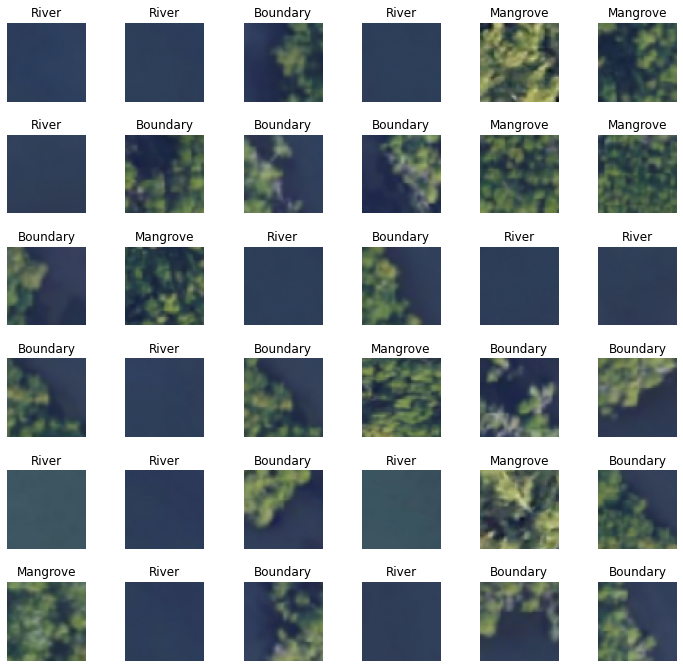

In [13]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

# IMPORT MODEL WITH PRETRAINED WEIGHTS

In [14]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(50,50,3)))

In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

# BUILD AND TRAIN DEEP LEARNING MODEL

In [17]:
headmodel = basemodel.output
#headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(64, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(64, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [19]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [20]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(50,50), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(50,50), class_mode= 'categorical', subset="validation")

Found 135 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [21]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 48, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

C:\Users\jonathan.tsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/48
33/33 [==============================] - 46s 880ms/step - loss: 1.3380 - accuracy: 0.3941 - val_loss: 1.1083 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.10834, saving model to weights.hdf5
Epoch 2/48
33/33 [==============================] - 24s 715ms/step - loss: 0.8874 - accuracy: 0.6155 - val_loss: 1.1572 - val_accuracy: 0.3333

Epoch 00002: val_loss did not improve from 1.10834
Epoch 3/48
33/33 [==============================] - 21s 642ms/step - loss: 0.7167 - accuracy: 0.6625 - val_loss: 2.3540 - val_accuracy: 0.4167

Epoch 00003: val_loss did not improve from 1.10834
Epoch 4/48
33/33 [==============================] - 24s 717ms/step - loss: 0.6664 - accuracy: 0.6573 - val_loss: 2.8132 - val_accuracy: 0.3333

Epoch 00004: val_loss did not improve from 1.10834
Epoch 5/48
33/33 [==============================] - 23s 696ms/step - loss: 0.4786 - accuracy: 0.7802 - val_loss: 5.8535 - val_accuracy: 0.3333

Epoch 00005: val_loss did not improve from 1.1

33/33 [==============================] - 20s 602ms/step - loss: 0.0143 - accuracy: 0.9862 - val_loss: 0.6328 - val_accuracy: 0.9167

Epoch 00042: val_loss did not improve from 0.05193
Epoch 43/48
33/33 [==============================] - 21s 644ms/step - loss: 4.2967e-04 - accuracy: 1.0000 - val_loss: 0.6994 - val_accuracy: 0.9167

Epoch 00043: val_loss did not improve from 0.05193
Epoch 44/48
33/33 [==============================] - 21s 643ms/step - loss: 0.1034 - accuracy: 0.9903 - val_loss: 0.7331 - val_accuracy: 0.9167

Epoch 00044: val_loss did not improve from 0.05193
Epoch 45/48
33/33 [==============================] - 19s 576ms/step - loss: 0.0133 - accuracy: 0.9980 - val_loss: 2.1656e-06 - val_accuracy: 1.0000

Epoch 00045: val_loss improved from 0.05193 to 0.00000, saving model to weights.hdf5
Epoch 46/48
33/33 [==============================] - 19s 588ms/step - loss: 0.0907 - accuracy: 0.9771 - val_loss: 1.9868e-08 - val_accuracy: 1.0000

Epoch 00046: val_loss improved from 0

#  EVALUATE TRAINED DEEP LEARNING MODEL

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

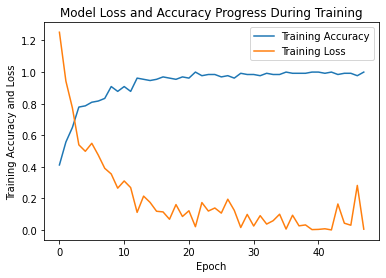

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

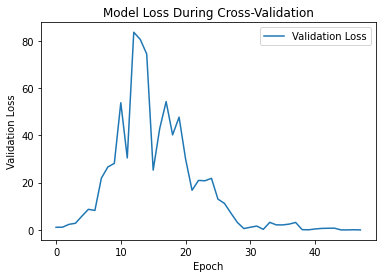

In [24]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

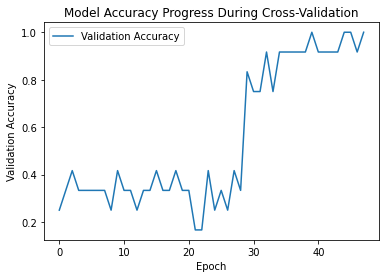

In [25]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [26]:
test_directory = '4. Operations Department/Test'


In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(50,50), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 3, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 41 images belonging to 3 classes.
 1/13 [=>............................] - ETA: 1s - loss: 0.1284 - accuracy: 1.0000

C:\Users\jonathan.tsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


13/13 [==============================] - 1s 35ms/step - loss: 0.8244 - accuracy: 0.8293
Accuracy Test : 0.8292682766914368


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(50,50))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,50,50,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [29]:
len(original)

41

In [30]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8048780487804879


IndexError: list index out of range

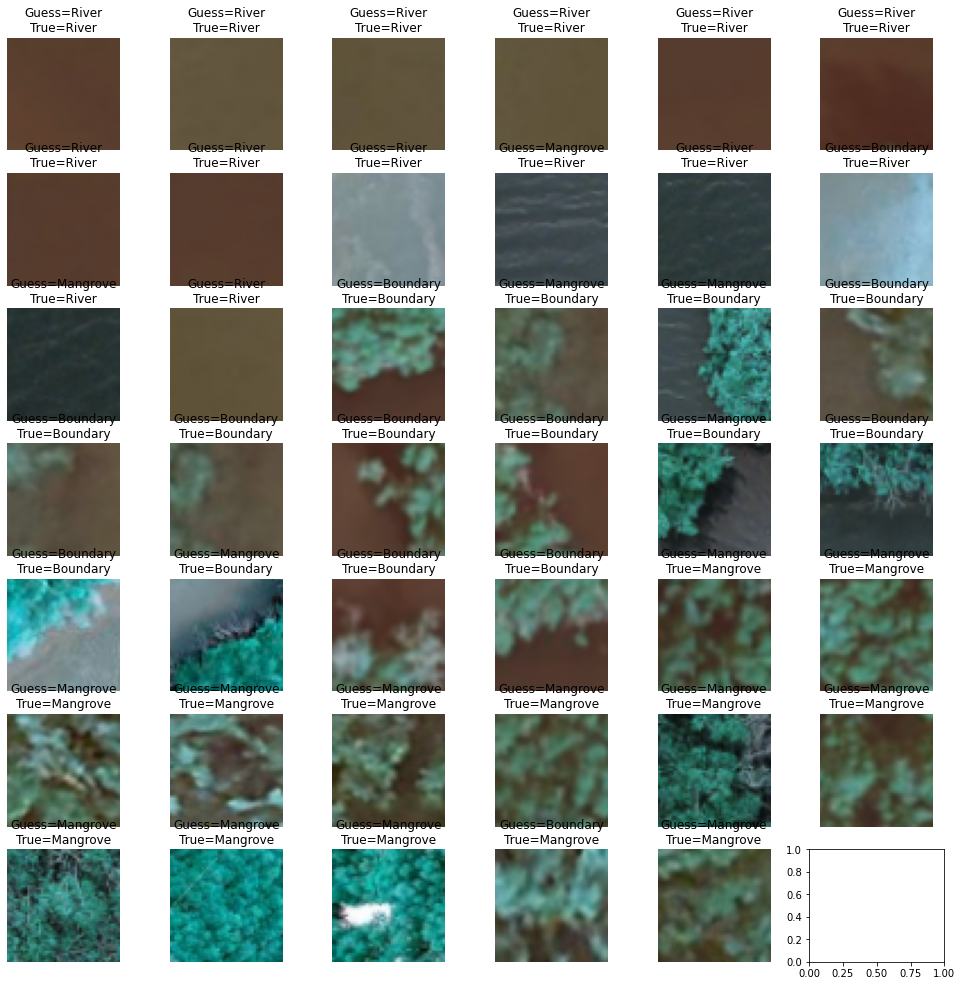

In [41]:
L = 7
W = 6

fig, axes = plt.subplots(L, W, figsize = (17, 17))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.0) 

In [32]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       0.83      0.71      0.77        14
           2       0.67      0.92      0.77        13

    accuracy                           0.80        41
   macro avg       0.83      0.81      0.81        41
weighted avg       0.84      0.80      0.81        41



Text(0.5, 1.0, 'Confusion_matrix')

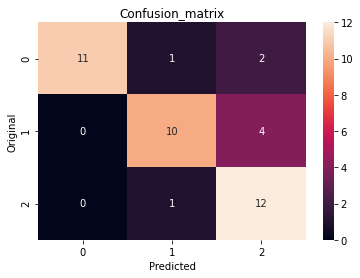

In [33]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')